In [1]:
# Pull data command:
# python download_data.py --project=discrete-mbrl-mf-chainging-best --history_vars step reward ep_length recon_loss --params env_name ae_model_type env_change_freq env_change_type rl_start_step ae_recon_loss

In [ ]:
import os
import sys
sys.path.append(os.path.abspath('../../..'))
from plotting_utils import *

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns

%matplotlib inline
set_matplotlib_style()

In [3]:
data_path = 'data/discrete-mbrl-mf-chainging-best_data.csv'
df = pd.read_csv(data_path, index_col=0)
# Fill nan in env_change_type column with 'random'
df['env_change_type'] = df['env_change_type'].fillna('random')
df['Model Type'] = df['ae_model_type']

model_type_dict = {
  'ae': 'Continuous',
  'vqvae': 'Discrete',
  'softmax_ae': 'Softmax',
  'fta_ae': 'FTA'
}
df['Model Type'] = df['Model Type'].apply(lambda x: model_type_dict[x])
df['Model Type'] = df.apply(
  (lambda x: x['Model Type'] if x['ae_recon_loss'] else 'End-to-End'), axis=1)

# Remove all softmax
df = df[df['ae_model_type'] != 'softmax_ae']
df['return'] = df['reward'] * df['ep_length']

# df = df.dropna()

df.head()

,step,reward,ep_length,recon_loss,ae_model_type,ae_recon_loss,e2e_loss,env_change_freq,env_name,rl_start_step,experiment_key,env_change_type,Model Type,return
0,2500,0.000660,320.571429,109.773088,ae,True,False,40000,minigrid-crossing-stochastic,0,7af1f1df43f640c4b29954d42511a4af,random,Continuous,0.211621
1,5000,0.001266,273.333333,9.575740,ae,True,False,40000,minigrid-crossing-stochastic,0,7af1f1df43f640c4b29954d42511a4af,random,Continuous,0.346040
2,7500,0.000358,355.857143,7.293831,ae,True,False,40000,minigrid-crossing-stochastic,0,7af1f1df43f640c4b29954d42511a4af,random,Continuous,0.127432
3,10000,0.002004,233.909091,6.901539,ae,True,False,40000,minigrid-crossing-stochastic,0,7af1f1df43f640c4b29954d42511a4af,random,Continuous,0.468824
4,12500,0.002019,232.454545,6.620704,ae,True,False,40000,minigrid-crossing-stochastic,0,7af1f1df43f640c4b29954d42511a4af,random,Continuous,0.469256


## Changing Env (Rand Order Delayed Start)

/tmp/ipykernel_21612/3315251961.py:8: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for env_name, group in df_subset.groupby(['env_name']):


Model Type
Continuous    30
Discrete      30
Name: experiment_key, dtype: int64


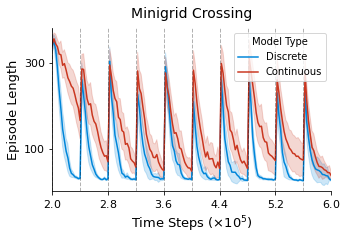

ae reward per step: 0.0096±0.0008
vqvae reward per step: 0.0169±0.0005
Model Type
Continuous    30
Discrete      30
Name: experiment_key, dtype: int64


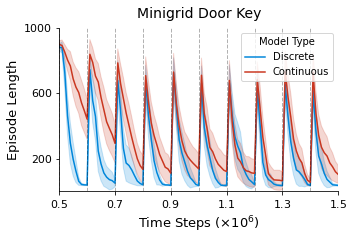

ae reward per step: 0.0087±0.0009
vqvae reward per step: 0.0132±0.0006


In [4]:
df_subset = df[
  (df['env_change_type'] == 'random') &
  (df['rl_start_step'] > 0) &
  df['env_name'].str.contains('-rand') &
  ((df['Model Type'] == 'Continuous') | (df['Model Type'] == 'Discrete'))
]

for env_name, group in df_subset.groupby(['env_name']):
  max_step = group['step'].max()
  env_change_freq = group.iloc[0]['env_change_freq']
  rl_start_step = group.iloc[0]['rl_start_step']

  print(group.groupby(['Model Type'])['experiment_key'].nunique())

  color_palette = get_color_palette(group['Model Type'].unique())
  sns.lineplot(
    group, x='step', y='ep_length', hue='Model Type',
    errorbar=t_distrib, palette=color_palette)
  
  for i in range(env_change_freq, max_step+1, env_change_freq):
    plt.axvline(x=i, color='black', linestyle='--', alpha=0.3, linewidth=1)
  
  plt.title(f'{standardize_env_name(env_name)}')

  set_fig_labels('Time Steps', 'Episode Length', xsci=True)

  plt.xticks(range(env_change_freq, max_step+1, 2*env_change_freq))

  mean_ep_lens = group.groupby(['step', 'Model Type'])['ep_length'].mean().values
  plt.ylim(0, np.percentile(mean_ep_lens, 95) * 1.05)
  
  yticks = plt.gca().get_yticks()
  plt.gca().set_yticks(yticks[1::2])
  
  plt.xlim(0, max_step)
  save_fig_versions(f'{standardize_env_name(env_name)}_full_changing_ep_len')
  plt.xlim(rl_start_step, max_step)
  save_fig_versions(f'{standardize_env_name(env_name)}_changing_ep_len')
  plt.show()

  for model_type, model_group in group.groupby('ae_model_type'):
    exp_groups = model_group.groupby('experiment_key')
    run_rewards = exp_groups['reward'].mean()
    ci = t_ci(run_rewards)
    print(f'{model_type} reward per step: {run_rewards.mean():.4f}±{ci:.4f}')

Model Type
Continuous    30
Discrete      30
End-to-End    30
FTA           30
Name: experiment_key, dtype: int64


/tmp/ipykernel_21612/1098724370.py:9: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for env_name, group in df_subset.groupby(['env_name']):


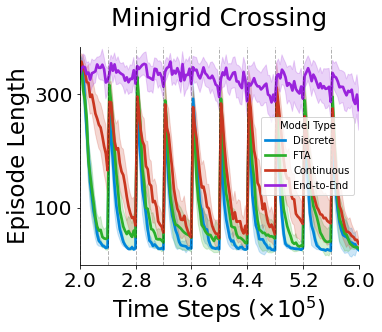

Continuous reward per step: 382.0853±33.4583
Discrete reward per step: 674.0182±21.4337
End-to-End reward per step: 28.2249±4.6364
FTA reward per step: 573.5378±56.8674
Model Type
Continuous    30
Discrete      30
End-to-End    30
FTA           30
Name: experiment_key, dtype: int64


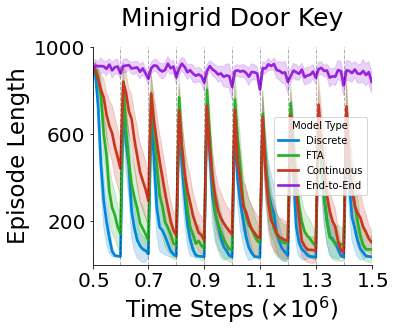

Continuous reward per step: 865.9033±93.7830
Discrete reward per step: 1324.1844±64.4478
End-to-End reward per step: 14.2781±1.6338
FTA reward per step: 1033.4198±129.9904


In [5]:
df_subset = df[
  (df['env_change_type'] == 'random') &
  (df['rl_start_step'] > 0) &
  df['env_name'].str.contains('-rand')
]

set_matplotlib_style(style='4-row')

for env_name, group in df_subset.groupby(['env_name']):
  max_step = group['step'].max()
  env_change_freq = group.iloc[0]['env_change_freq']
  rl_start_step = group.iloc[0]['rl_start_step']

  print(group.groupby(['Model Type'])['experiment_key'].nunique())

  color_palette = get_color_palette(group['Model Type'].unique())
  sns.lineplot(
    group, x='step', y='ep_length', hue='Model Type',
    errorbar=t_distrib, palette=color_palette)
  
  for i in range(env_change_freq, max_step+1, env_change_freq):
    plt.axvline(x=i, color='black', linestyle='--', alpha=0.3, linewidth=1)
  
  plt.title(f'{standardize_env_name(env_name)}')

  set_fig_labels('Time Steps', 'Episode Length', xsci=True)

  plt.xticks(range(env_change_freq, max_step+1, 2*env_change_freq))

  mean_ep_lens = group.groupby(['step', 'Model Type'])['ep_length'].mean().values
  plt.ylim(0, np.percentile(mean_ep_lens, 95) * 1.05)
  
  yticks = plt.gca().get_yticks()
  plt.gca().set_yticks(yticks[1::2])
  
  plt.xlim(0, max_step)
  save_fig_versions(f'{standardize_env_name(env_name)}_full_changing_ep_len_baselines')
  plt.xlim(rl_start_step, max_step)
  save_fig_versions(f'{standardize_env_name(env_name)}_changing_ep_len_baselines')
  plt.show()


  for model_type, model_group in group.groupby('Model Type'):
    exp_groups = model_group.groupby('experiment_key')
    run_rewards = exp_groups['reward'].mean()
    ci = t_ci(run_rewards)
    print(f'{model_type} reward per step: {env_change_freq*run_rewards.mean():.4f}±{env_change_freq*ci:.4f}')

  # task_avg_rewrads = {'Discrete': [], 'Continuous': [], 'FTA': []}
  # for i in range(env_change_freq, max_step+1, env_change_freq):

## Changing env recon loss (better generalization?)

/tmp/ipykernel_21612/3953541277.py:10: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for env_name, group in df_subset.groupby(['env_name']):


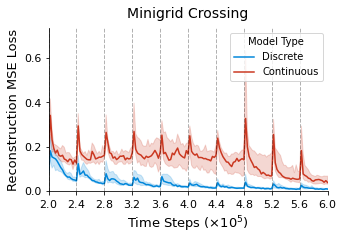

ae reward per step: 0.0096±0.0008
vqvae reward per step: 0.0169±0.0005


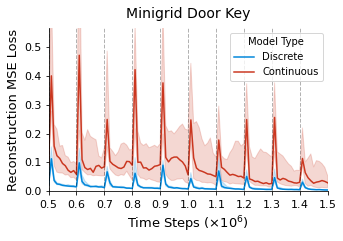

ae reward per step: 0.0087±0.0009
vqvae reward per step: 0.0132±0.0006


In [6]:
df_subset = df[
  (df['env_change_type'] == 'random') &
  (df['rl_start_step'] > 0) &
  df['env_name'].str.contains('-rand') &
  ((df['Model Type'] == 'Continuous') | (df['Model Type'] == 'Discrete'))
]

set_matplotlib_style()

for env_name, group in df_subset.groupby(['env_name']):
  # Count the number of runs for each ae_model_type
  max_step = group['step'].max()
  env_change_freq = group.iloc[0]['env_change_freq']
  rl_start_step = group.iloc[0]['rl_start_step']

  color_palette = get_color_palette(group['Model Type'].unique())
  sns.lineplot(
    group, x='step', y='recon_loss', hue='Model Type',
    errorbar='ci', palette=color_palette, estimator=np.median)
  
  for i in range(env_change_freq, max_step+1, env_change_freq):
    plt.axvline(x=i, color='black', linestyle='--', alpha=0.3, linewidth=1)
  
  plt.title(f'{standardize_env_name(env_name)}')
  set_fig_labels('Time Steps', 'Reconstruction MSE Loss', xsci=True)

  plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

  plt.xticks(range(0, max_step+1, env_change_freq))
  plt.ylim(0, np.percentile(group['recon_loss'], 85))
  
  plt.xlim(0, max_step)
  save_fig_versions(f'{standardize_env_name(env_name)}_full_changing_recon')
  plt.xlim(rl_start_step, max_step)
  save_fig_versions(f'{standardize_env_name(env_name)}_changing_recon')
  plt.show()

  for model_type, model_group in group.groupby('ae_model_type'):
    exp_groups = model_group.groupby('experiment_key')
    run_rewards = exp_groups['reward'].mean()
    ci = t_ci(run_rewards)
    print(f'{model_type} reward per step: {run_rewards.mean():.4f}±{ci:.4f}')


/tmp/ipykernel_21612/921306933.py:10: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for env_name, group in df_subset.groupby(['env_name']):


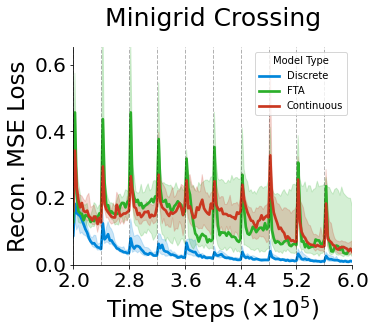

ae reward per step: 0.0096±0.0008
fta_ae reward per step: 0.0143±0.0014
vqvae reward per step: 0.0169±0.0005


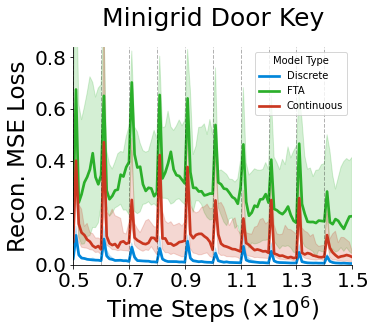

ae reward per step: 0.0087±0.0009
fta_ae reward per step: 0.0103±0.0013
vqvae reward per step: 0.0132±0.0006


In [7]:
df_subset = df[
  (df['env_change_type'] == 'random') &
  (df['rl_start_step'] > 0) &
  df['env_name'].str.contains('-rand') &
  df['ae_recon_loss']
]

set_matplotlib_style(style='4-row')

for env_name, group in df_subset.groupby(['env_name']):
  # Count the number of runs for each ae_model_type
  max_step = group['step'].max()
  env_change_freq = group.iloc[0]['env_change_freq']
  rl_start_step = group.iloc[0]['rl_start_step']

  color_palette = get_color_palette(group['Model Type'].unique())
  sns.lineplot(
    group, x='step', y='recon_loss', hue='Model Type',
    errorbar='ci', palette=color_palette, estimator=np.median)
  
  for i in range(env_change_freq, max_step+1, env_change_freq):
    plt.axvline(x=i, color='black', linestyle='--', alpha=0.3, linewidth=1)
  
  plt.title(f'{standardize_env_name(env_name)}')
  set_fig_labels('Time Steps', 'Recon. MSE Loss', xsci=True)

  plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

  plt.xticks(range(0, max_step+1, env_change_freq))
  plt.ylim(0, np.percentile(group['recon_loss'], 83))

  xticks = plt.gca().get_xticks()
  plt.gca().set_xticks(xticks[1::2])
  
  plt.xlim(0, max_step)
  save_fig_versions(f'{standardize_env_name(env_name)}_full_changing_recon_baselines')

  plt.xlim(rl_start_step, max_step)
  # xticks = plt.gca().get_xticks()
  # plt.gca().set_xticks(xticks[1::2])
  save_fig_versions(f'{standardize_env_name(env_name)}_changing_recon_baselines')
  plt.show()

  for model_type, model_group in group.groupby('ae_model_type'):
    exp_groups = model_group.groupby('experiment_key')
    run_rewards = exp_groups['reward'].mean()
    ci = t_ci(run_rewards)
    print(f'{model_type} reward per step: {run_rewards.mean():.4f}±{ci:.4f}')
